### refining the original 'goal' figure

an attempt to refine and try some different visualizations of $N/N_{CDM}(z)$ for the final presentations of the summer, starting with the code from the *hmf_ratios* notebook as a base.

In [1]:
#...... general imports

import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from tqdm import tqdm

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist # custom object

#...... plot formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = (0.0, 0.0, 0.0, 0.0)



#...... colors 

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

In [44]:
halo_id = 'Halo004'

#...... cold dark matter
model = 'cdm'

cdm = hlist(halo_id=halo_id, model=model, high_resolution=False)
cdm.load_hlists()
cdm.load_hmb()

#...... warm dark matter, 3 keV
model = 'wdm_6'
wdm = hlist(halo_id=halo_id, model=model)
wdm.load_hlists()
wdm.load_hmb()

In [45]:
def get_relative_number(model: hlist = cdm, mass: float = 1e8, bin_percent: float = 0.1, z_cutoff: float = 4.5, relative_z: bool = False, cdm_ratio: bool = True, mass_def: str = 'Mpeak'):

    '''
    Calculates the relative number of subhalos (N/N_CDM) for both CDM at z = 0 and z = rel. as a function of redshift within range of a defined mass (default bin is narrow, +/- 0.1). 
    Also allows for user defined adjustment of the upper redshift limit (default is z = 4.5)
    '''
    
    a_range = [ a for a in list(model.dict.keys()) if (1.0/a) - 1.0 < z_cutoff] # gets all scale factors below cutoff
    ratios = np.zeros((len(a_range), ))

    for i, a in enumerate(tqdm(a_range)):

        # get subhalos
        halos, subhalos = model.get_a(a)
        
        if cdm_ratio:

            if relative_z:
                halos_cdm, subhalos_cdm = cdm.get_a(a) # normalized to cdm at z = rel.
            else:
                halos_cdm, subhalos_cdm = cdm.get_a(1) # normalized to cdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos[mass_def]/0.7 > (1 - bin_percent)*mass 
            b = subhalos[mass_def]/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = a == b
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_cdm[mass_def]/0.7 > (1 - bin_percent)*mass 
            b = subhalos_cdm[mass_def]/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_cdm = (a == b)
            n_cdm = np.sum(mass_cut_ind_cdm)

            ratios[i] = n/n_cdm # calculates the numerical ratio
            
        else:

            halos_wdm, subhalos_wdm = model.get_a(1) # normalized to wdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos[mass_def]/0.7 > (1 - bin_percent)*mass 
            b = subhalos[mass_def]/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = (a == b)
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_wdm[mass_def]/0.7 > (1 - bin_percent)*mass 
            b = subhalos_wdm[mass_def]/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_wdm = (a == b)
            n_wdm = np.sum(mass_cut_ind_wdm)

            ratios[i] = n/n_wdm # calculates the numerical ratio
            

    return ratios, [(1.0/a) - 1.0 for a in a_range]

### warm dark matter

100%|██████████| 134/134 [04:41<00:00,  2.10s/it]


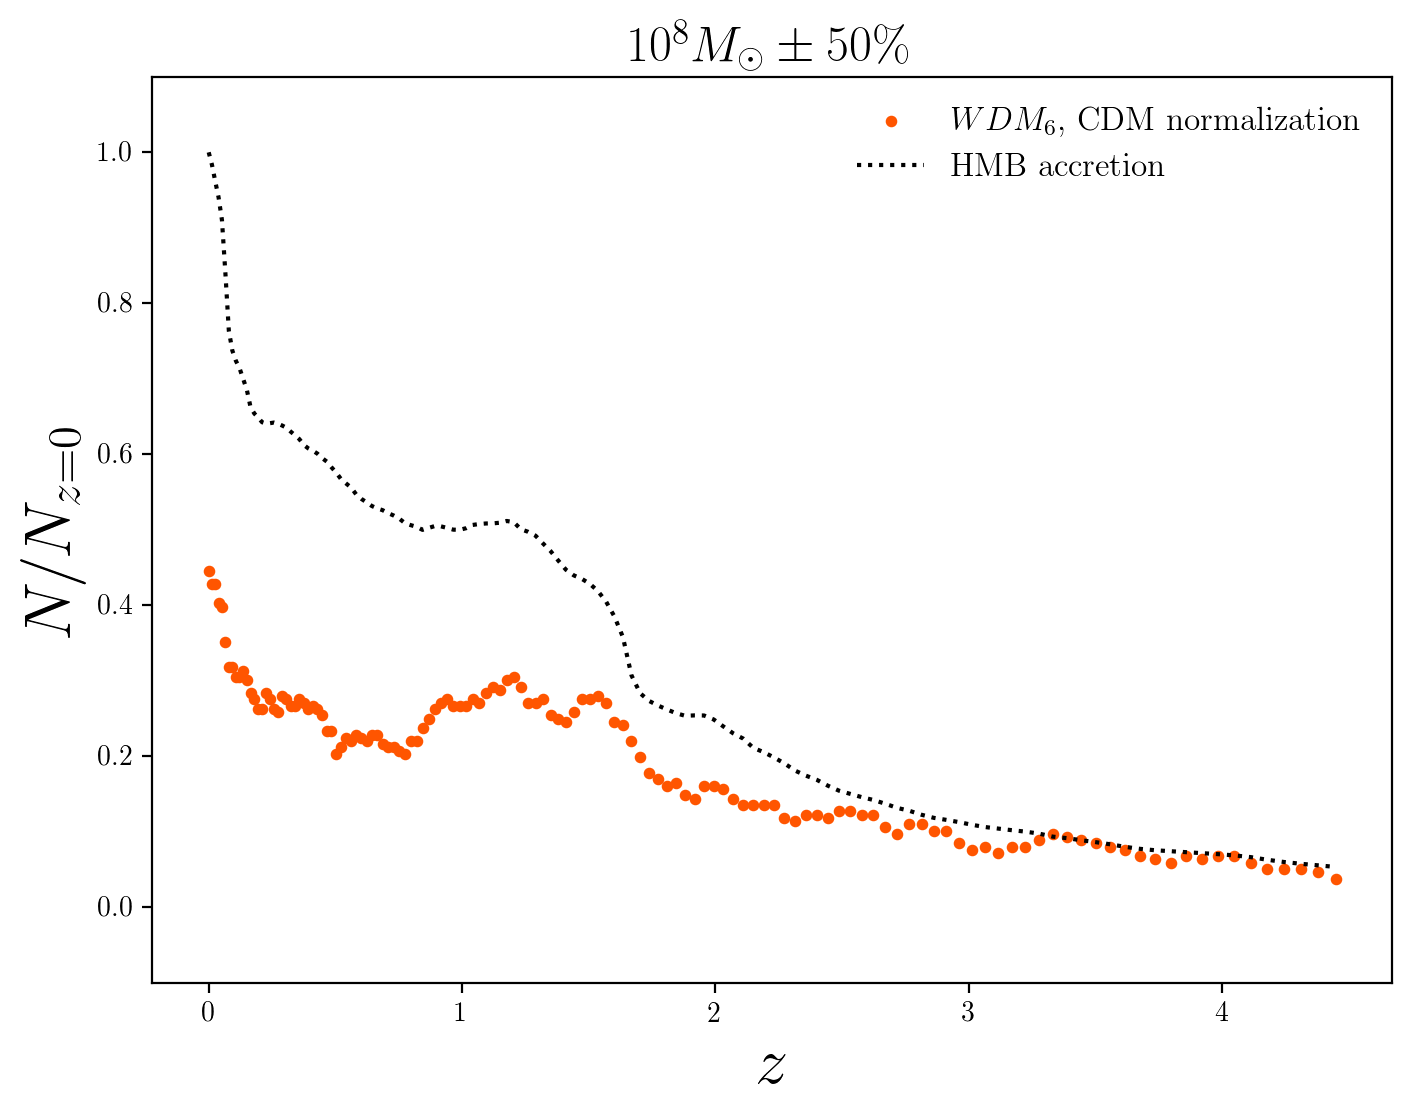

In [5]:
mass = 8

r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
# r_rel, z_rel = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=False)

redshift_cut = 1./wdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./wdm.hmb['scale'] - 1.
mass_hmb = wdm.hmb['mvir']/wdm.hmb['mvir'][0] # virial mass


plt.figure(figsize=(8,6))
plt.scatter(z, r, c=sim_colors['wdm_6'], label=r'$WDM_6$, CDM normalization', s=10)
# plt.scatter(z_rel, r_rel, c=sim_colors['wdm_6'], label=r'$WDM_3$, WDM normalization', s=10)
plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='HMB accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{z=0}$', fontsize=24)
plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

#### wdm, stationary redshift

100%|██████████| 134/134 [04:58<00:00,  2.23s/it]


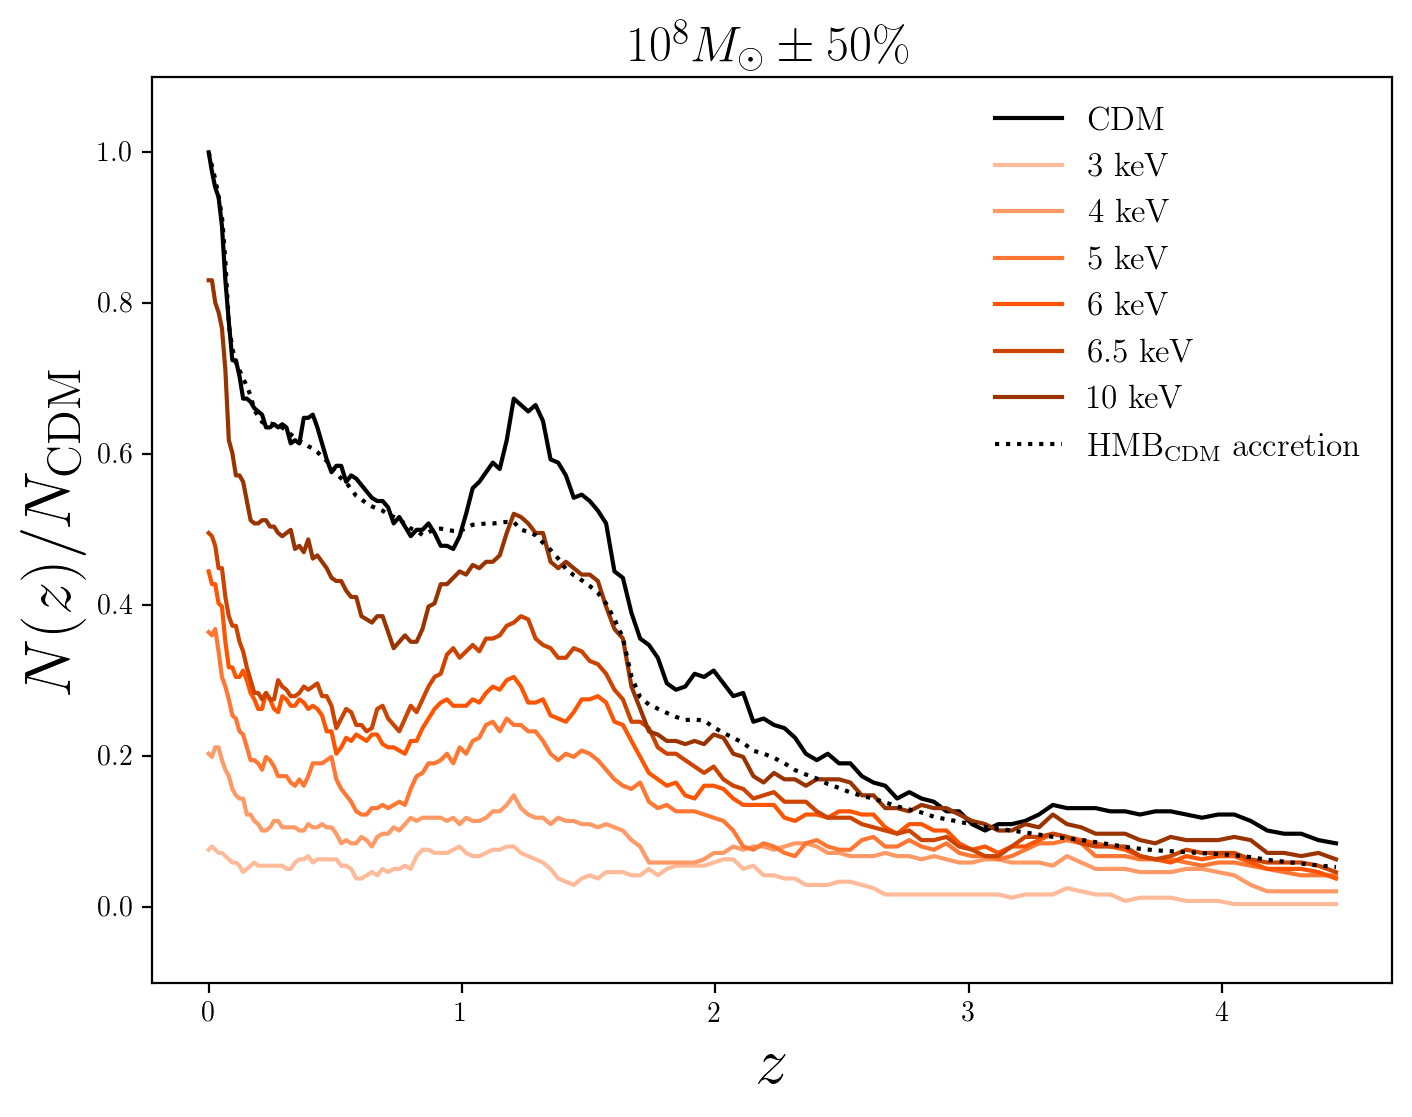

In [46]:
mass = 8

plt.figure(figsize=(8,6))
redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
plt.plot(z, r, c=sim_colors['cdm'], label=r'CDM')

models = ['wdm_3', 'wdm_4', 'wdm_5', 'wdm_6', 'wdm_6.5', 'wdm_10']
for model in models:
    
    wdm = hlist(halo_id=halo_id, model=model, high_resolution=False)
    wdm.load_hlists()
    wdm.load_hmb()

    r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
    plt.plot(z, r, c=sim_colors[model], label=f'{model[4:]} keV')
#     plt.scatter(z, r, c=sim_colors[model], label=f'{model[4:]} keV', s=10)

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$\mathrm{HMB_{CDM}}$ accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{\mathrm{CDM(z=0)}}$', fontsize=24)
plt.ylabel(r'$N(z)/N_{\mathrm{CDM}}$', fontsize=24)
plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

100%|██████████| 134/134 [06:21<00:00,  2.85s/it]


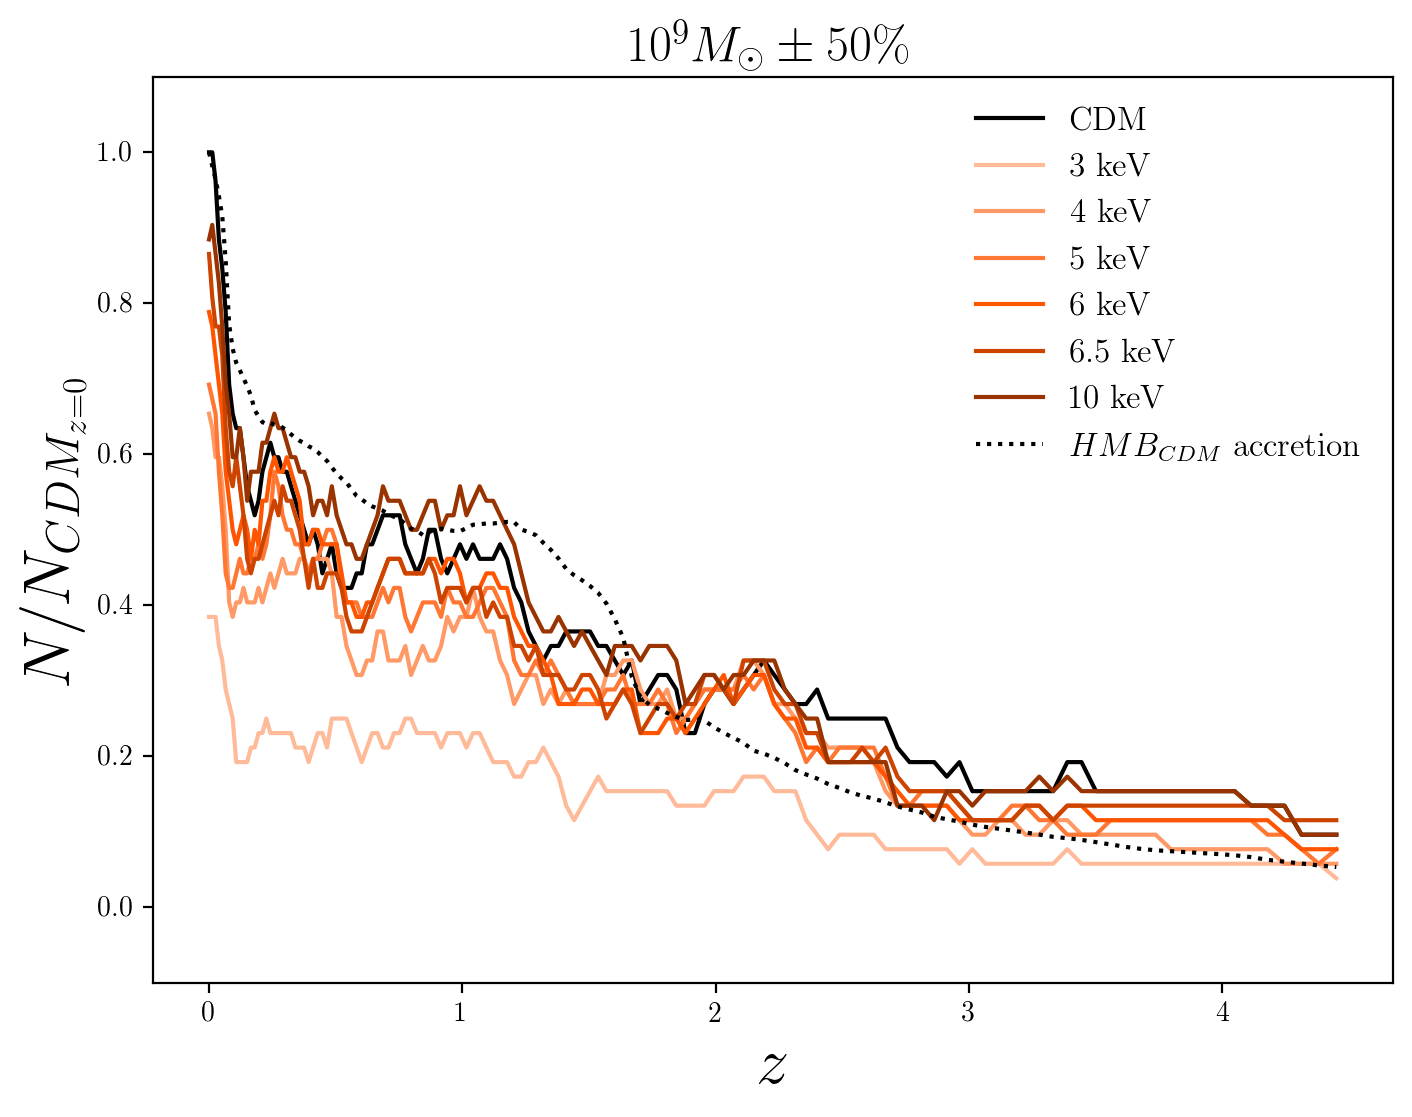

In [8]:
mass = 9

plt.figure(figsize=(8,6))
redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
plt.plot(z, r, c=sim_colors['cdm'], label=r'CDM')

models = ['wdm_3', 'wdm_4', 'wdm_5', 'wdm_6', 'wdm_6.5', 'wdm_10']
for model in models:
    
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
    plt.plot(z, r, c=sim_colors[model], label=f'{model[4:]} keV')
#     plt.scatter(z, r, c=sim_colors[model], label=f'{model[4:]} keV', s=10)

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$HMB_{CDM}$ accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=24)
plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

#### wdm, relative redshift

100%|██████████| 134/134 [06:55<00:00,  3.10s/it]


Text(0.5, 1.0, '$10^{8} M_\\odot \\pm 50\\%$')

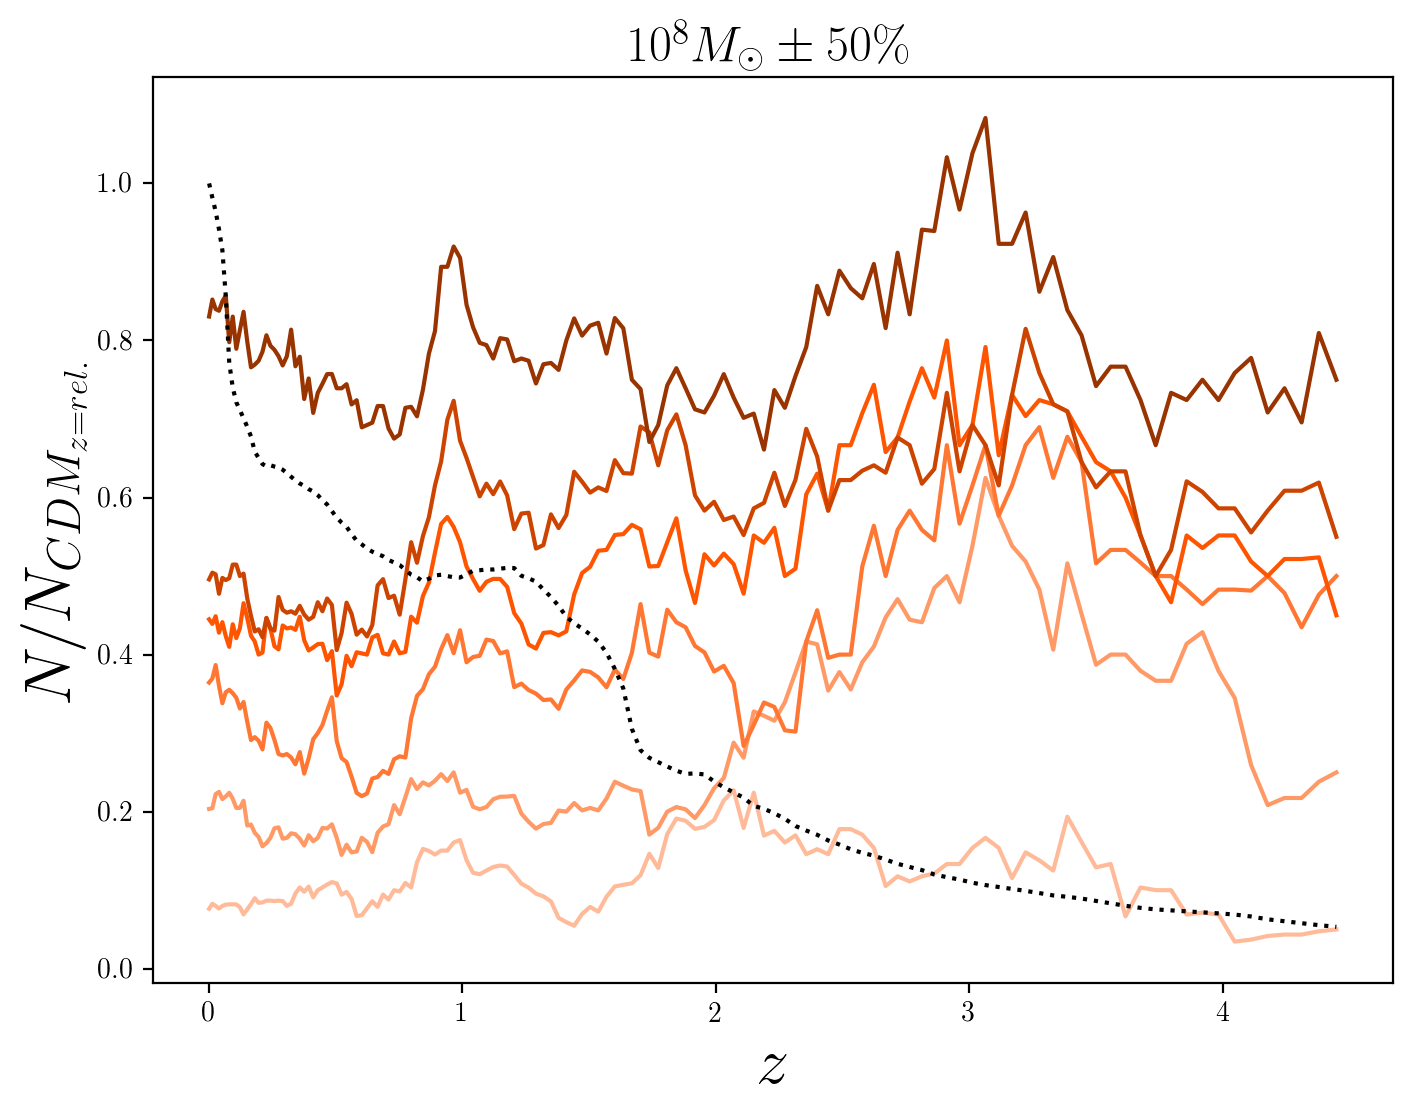

In [10]:
mass = 8

plt.figure(figsize=(8,6))
redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

models = ['wdm_3', 'wdm_4', 'wdm_5', 'wdm_6', 'wdm_6.5', 'wdm_10']
for model in models:
    
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True, relative_z=True)
    plt.plot(z, r, c=sim_colors[model], label=f'{model[4:]} keV')
#     plt.scatter(z, r, c=sim_colors[model], label=f'{model[4:]} keV', s=10)

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$HMB_{CDM}$ accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{CDM_{z=rel.}}$', fontsize=24)
plt.title(r'$10^{8} M_\odot \pm 50\%$', fontsize=18)
# plt.ylim(-0.1, 1.1)
# plt.yscale('log')
# plt.legend(fontsize=12, frameon=False)

### fuzzy dark matter

100%|██████████| 134/134 [06:25<00:00,  2.88s/it]


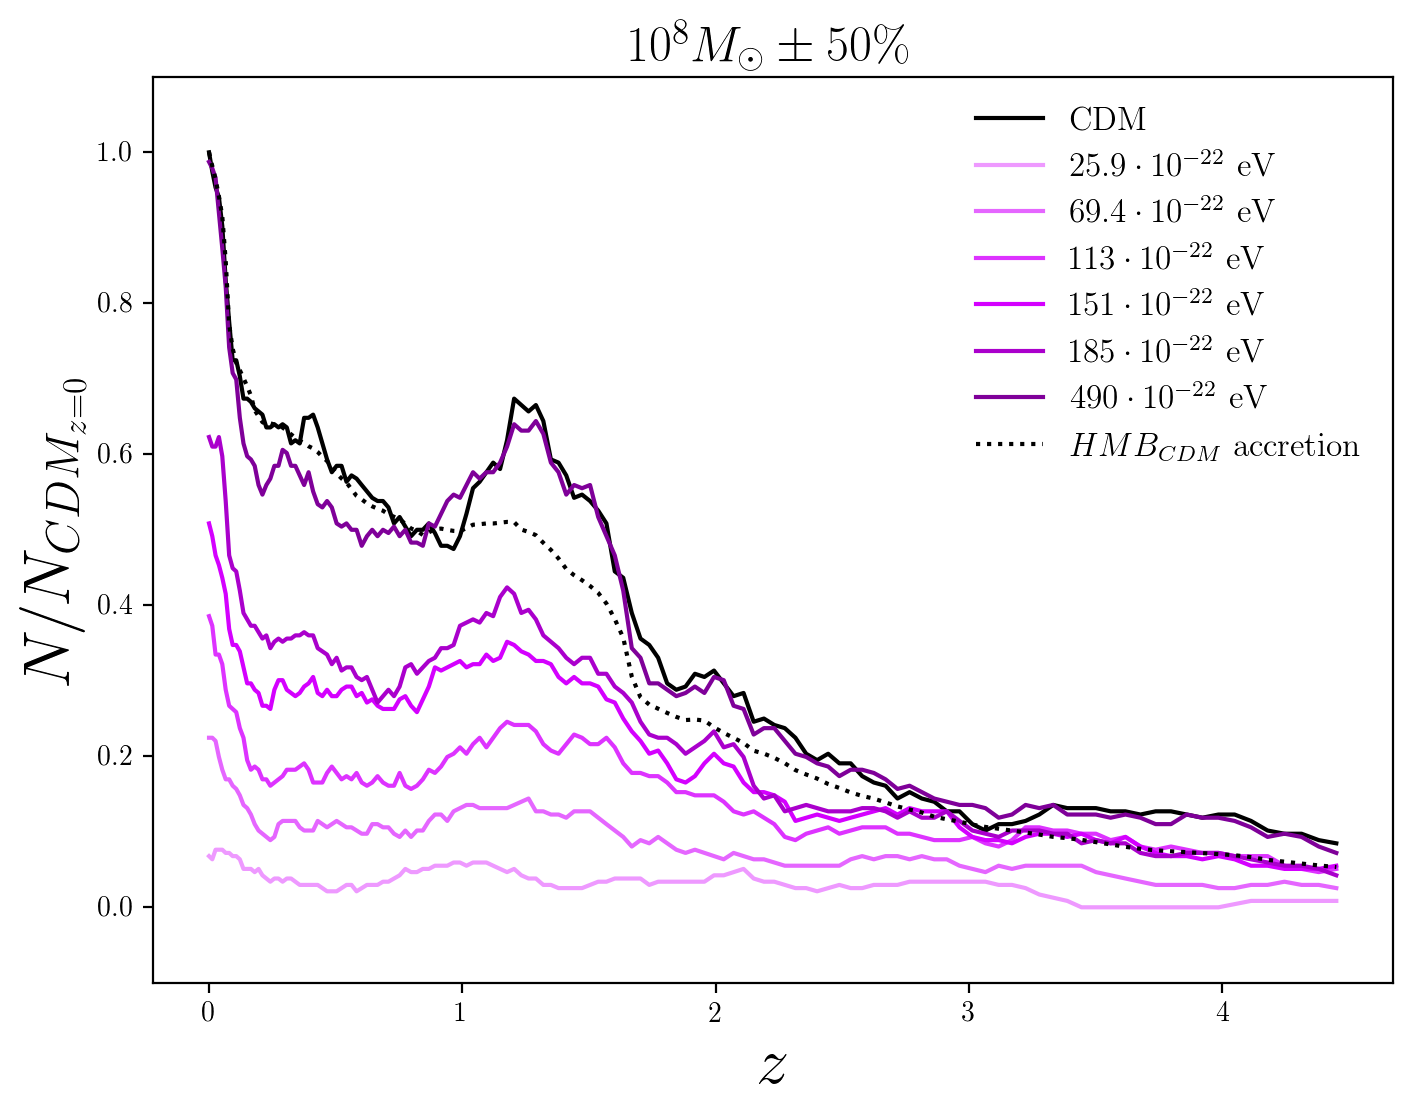

In [11]:
mass = 8

plt.figure(figsize=(8,6))
redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
plt.plot(z, r, c=sim_colors['cdm'], label=r'CDM')

models = ['fdm_25.9e-22eV', 'fdm_69.4e-22eV', 'fdm_113e-22eV', 'fdm_151e-22eV', 'fdm_185e-22eV', 'fdm_490e-22eV'] 
labels = ['$25.9 \cdot 10^{-22}$ eV', '$69.4 \cdot 10^{-22}$ eV', '$113 \cdot 10^{-22}$ eV', '$151 \cdot 10^{-22}$ eV', '$185 \cdot 10^{-22}$ eV', '$490 \cdot 10^{-22}$ eV']

for i, model in enumerate(models):
    
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
    plt.plot(z, r, c=sim_colors[model], label=labels[i])
#     plt.scatter(z, r, c=sim_colors[model], label=f'{model[4:]} keV', s=10)

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$HMB_{CDM}$ accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=24)
plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

### self-interacting dark matter

In [13]:
# mass = 8

# plt.figure(figsize=(8,6))
# redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

# z_hmb = 1./cdm.hmb['scale'] - 1.
# mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

# r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
# plt.plot(z, r, c=sim_colors['cdm'], label=r'CDM')

# models = ['idm_1e-4GeV_envelope', 'idm_1e-2GeV_envelope', 'idm_1GeV_envelope', 'idm_1e-4GeV_halfmode', 'idm_1e-2GeV_halfmode', 'idm_1GeV_halfmode']
# labels = ['$1^{-4}$ GeV, envelope', '$1^{-2}$ GeV, envelope', '$1$ GeV, envelope', '$1^{-4}$ GeV, halfmode', '$1^{-2}$ GeV, halfmode', '$1$ GeV, halfmode']

# for i, model in enumerate(models[:3]):
    
#     wdm = hlist(halo_id=halo_id, model=model)
#     wdm.load_hlists()
#     wdm.load_hmb()

#     r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
#     plt.plot(z, r, c=sim_colors[model[:-9]], label=labels[i])
    
# for i, model in enumerate(models[3:]):
    
#     wdm = hlist(halo_id=halo_id, model=model)
#     wdm.load_hlists()
#     wdm.load_hmb()

#     r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
#     plt.plot(z, r, c=sim_colors[model[:-9]], label=labels[i], linestyle='--')


# plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$HMB_{CDM}$ accretion', c='k', linestyle=':')
# plt.xlabel(r'$z$', fontsize=24)
# plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=24)
# plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
# plt.ylim(-0.1, 1.1)
# # plt.yscale('log')
# plt.legend(fontsize=12, frameon=False)

### cold dark matter

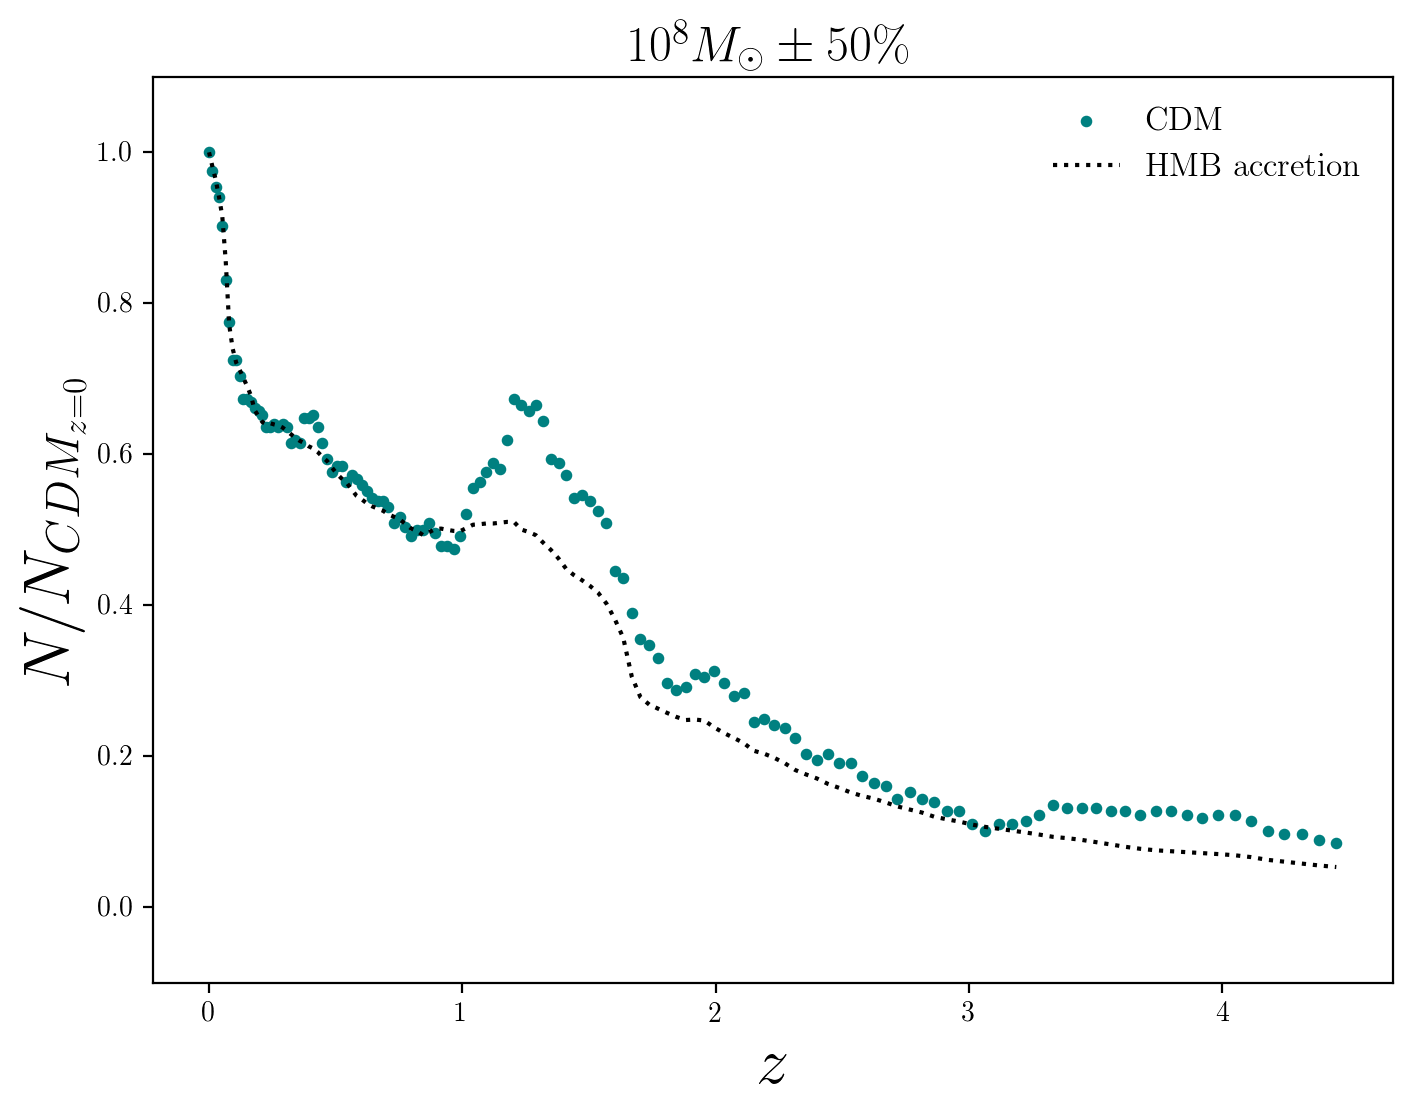

In [23]:
mass = 8

# r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
# r_error = 1./np.sqrt(r)

redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass


plt.figure(figsize=(8,6))
plt.scatter(z, r, c='teal', label=r'CDM', s=10)
# plt.fill_between(z, r + r_error, r - r_error, color='teal', alpha = 0.3, label='CDM error')

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='HMB accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=24)
plt.title(r'$10^{8} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

### host main branch check

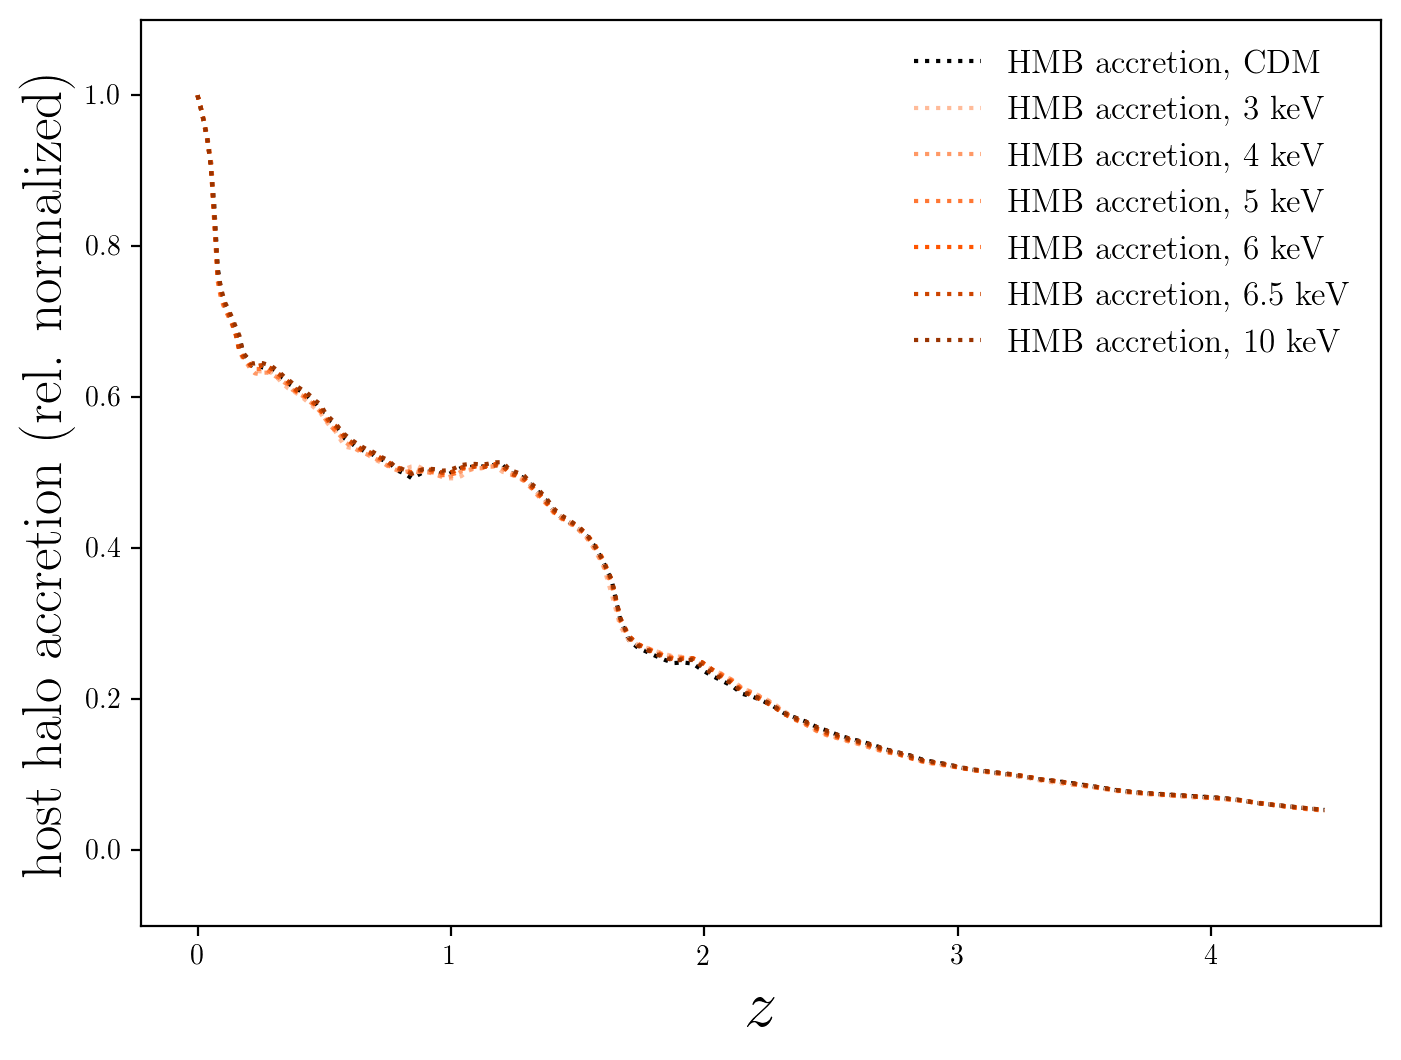

In [10]:
models = ['wdm_3', 'wdm_4', 'wdm_5', 'wdm_6', 'wdm_6.5', 'wdm_10']

plt.figure(figsize=(8,6))

redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='HMB accretion, CDM', c='k', linestyle=':')

for model in models:
    
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()
    
    redshift_cut = 1./wdm.hmb['scale'] - 1. < 4.5

    z_hmb = 1./wdm.hmb['scale'] - 1.
    mass_hmb = wdm.hmb['mvir']/wdm.hmb['mvir'][0] # virial mass
    
    plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label=f'HMB accretion, {model[4:]} keV', c=sim_colors[model], linestyle=':')
    
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel('host halo accretion (rel. normalized)', fontsize=20)
# plt.title(r'$10^{8} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=12, frameon=False)

In [2]:
model='cdm'

h004 = hlist(model=model, halo_id='Halo004')
h023 = hlist(model=model, halo_id='Halo023')
h113 = hlist(model=model, halo_id='Halo113')

h004.load_hmb()
h023.load_hmb()
h113.load_hmb()

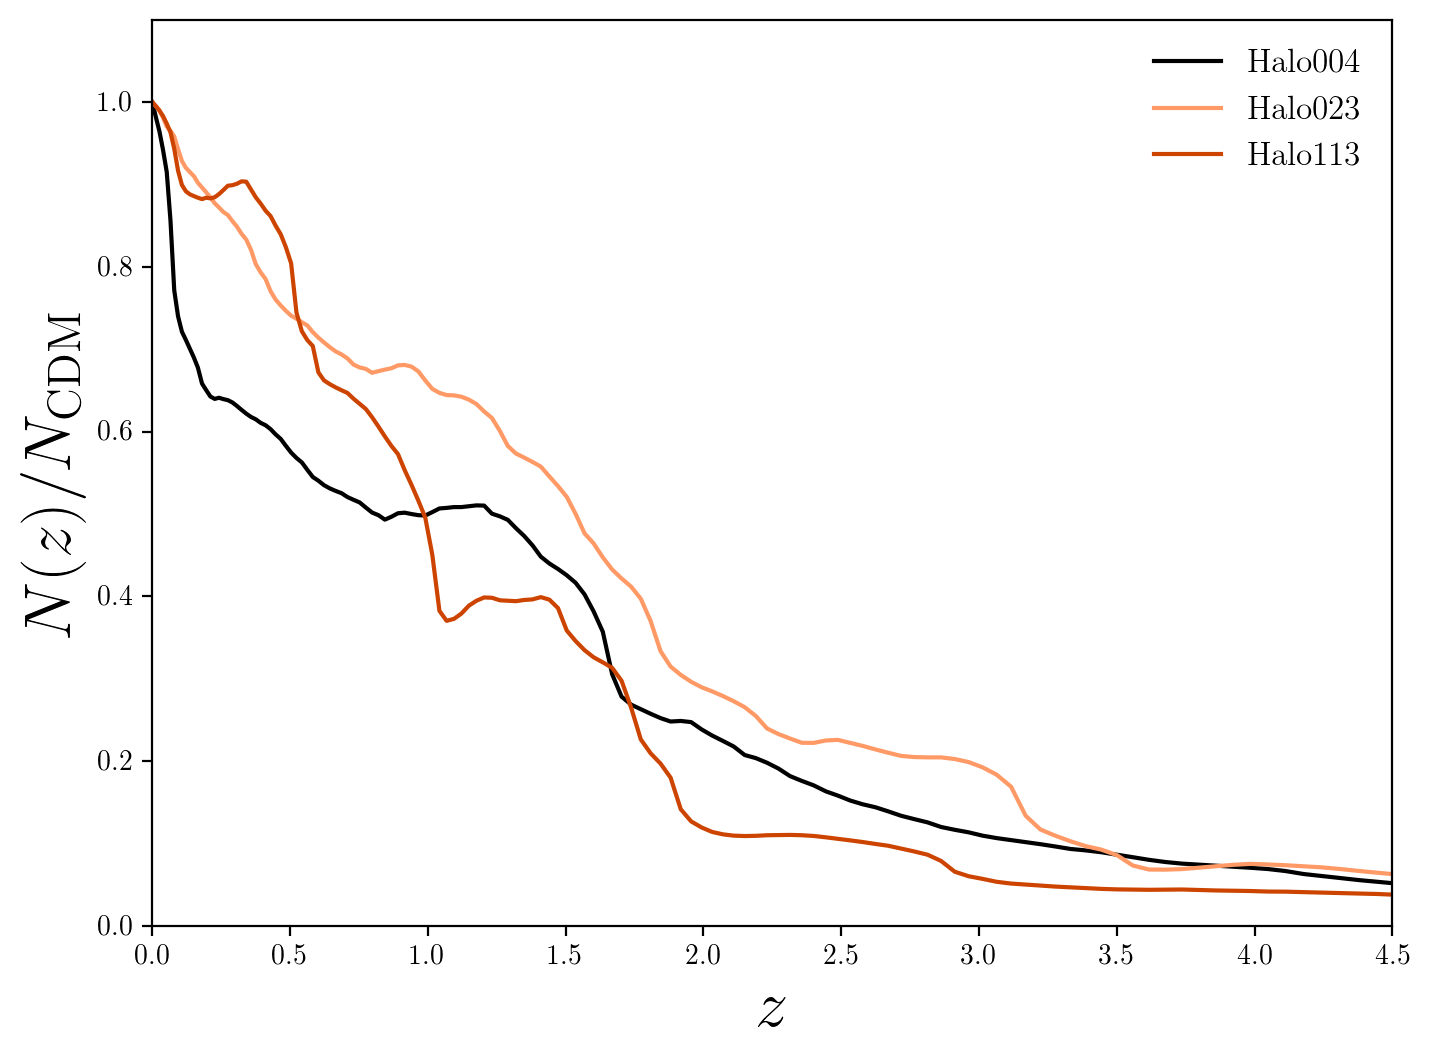

In [40]:
plt.figure(figsize=(8,6))

plt.plot(1./h004.hmb['scale'] - 1., h004.hmb['mvir']/h004.hmb['mvir'][0], label='Halo004', c='k')
plt.plot(1./h023.hmb['scale'] - 1., h023.hmb['mvir']/h023.hmb['mvir'][0], label='Halo023', c=sim_colors['wdm_4'])
plt.plot(1./h113.hmb['scale'] - 1., h113.hmb['mvir']/h113.hmb['mvir'][0], label='Halo113', c=sim_colors['wdm_6.5'])

plt.xlabel(r'$z$', fontsize=24)
plt.ylabel('host halo accretion (rel. normalized)', fontsize=20)
plt.ylim(0, 1.1)
plt.xlim(0, 4.5)
plt.legend(fontsize=12, frameon=False)

## using $M_{vir}$, same models

#### warm dark matter, stationary z

100%|██████████| 134/134 [05:21<00:00,  2.40s/it]


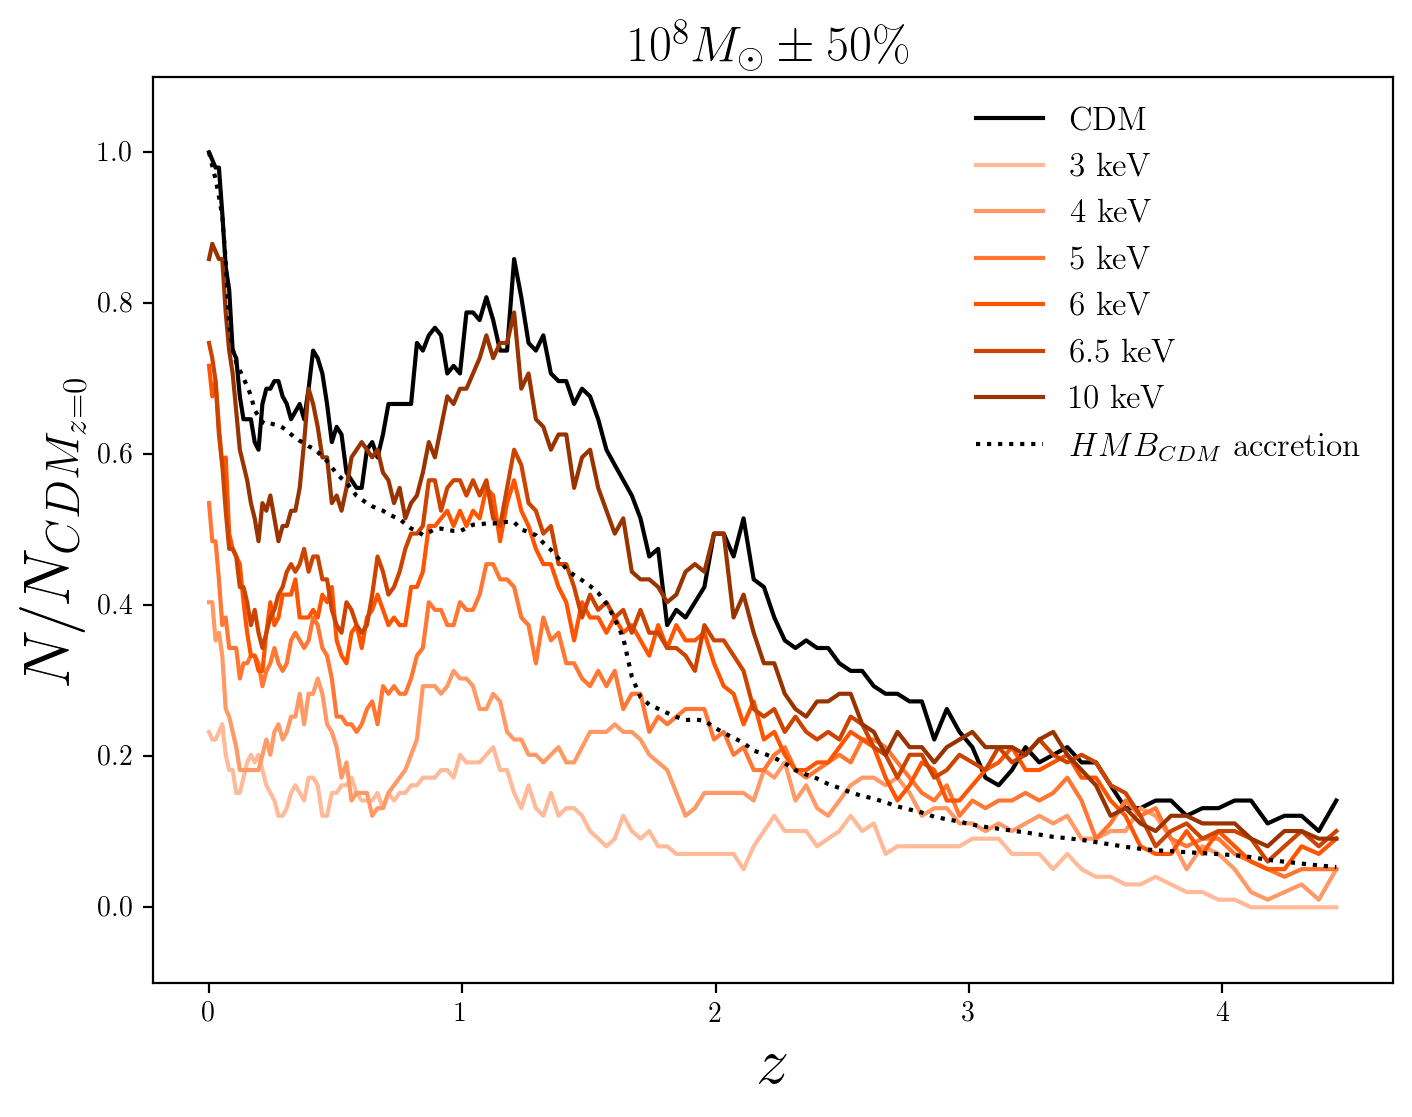

In [6]:
mass = 8

plt.figure(figsize=(8,6))
redshift_cut = 1./cdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./cdm.hmb['scale'] - 1.
mass_hmb = cdm.hmb['mvir']/cdm.hmb['mvir'][0] # virial mass

r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5, mass_def= 'Mvir')
plt.plot(z, r, c=sim_colors['cdm'], label=r'CDM')

models = ['wdm_3', 'wdm_4', 'wdm_5', 'wdm_6', 'wdm_6.5', 'wdm_10']
for model in models:
    
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True, mass_def= 'Mvir')
    plt.plot(z, r, c=sim_colors[model], label=f'{model[4:]} keV')
#     plt.scatter(z, r, c=sim_colors[model], label=f'{model[4:]} keV', s=10)

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='$HMB_{CDM}$ accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{CDM_{z=0}}$', fontsize=24)
plt.title(f'$10^{mass} M_\odot \pm 50\%$', fontsize=18)
plt.ylim(-0.1, 1.1)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

In [9]:
cdm = hlist(model='cdm', halo_id=halo_id, high_resolution=True)
cdm.load_hmb()
cdm.load_hlists()

halos, subhalos = cdm.get_z(z=0)

In [16]:
halos

array([(1., 56005717, 0., -1, 202, -1, -1, -1, 0, 7.20500e+11, 7.205e+11, 184.172, 17.825, 170.12, 1, 0.37953, 160.26, 64.76939, 62.80089, 64.83501, 137.11, 61.89, 127.68,  4.285e+11,  2.131e+10, 7.457e+11, 0.03401,        0,        0, 56005717,  76084, 235., -1,  2485742,      235, 0.     ,       -1, 16.5147 , 7.2207e+11, 7.6320e+11, 6.2876e+11, 5.1387e+11, 2.4929e+11, 10.4268 , 51.15, 0.03534, 0.61004, 0.50632, -1.13466, 4.64905, 3.64458, 0.5714 , 0.44371, -0.5079 , 4.04437, 3.01156, 0.6459, 9.108e+11, 4.202e+11, 60.337, 7.205e+11, 7.205e+11, 160.26, 161.35, 0.44226,  7.544e+01,  7.544e+01,  1.130e+02,  6.923e+01, 6.012e+01,  1.681e-10,  2.417e-11, 1.     , 1., 1., 7.205e+11, 160.26, 160.26, 0.     ,  0.04794, -1., 56005717),
       (1., 56078543, 0., -1,  25, -1, -1, -1, 0, 7.46332e+10, 7.413e+10,  86.297,  4.258,  83.69, 1, 0.18825,  85.62, 65.24243, 64.70792, 66.72981, 148.07, 53.29,  84.07, -1.784e+10,  3.040e+09, 7.750e+09, 0.04215,  2932212,  2932212, 56078543, 145385, 235., -1